In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def load_file_from_excel(file_path):
    df = pd.ExcelFile(file_path)
    df = pd.read_excel(df, df.sheet_names[0])
    return df

In [4]:
greedy= load_file_from_excel("/home/dt-021/Documents/sagemaker/ID_counts1.xlsx")

In [5]:
values=greedy['CTR'].as_matrix()

/home/dt-021/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [6]:
values2=greedy['Scaled CLPS']

In [7]:
bandit_probs = values2  # bandit probabilities of success
N_experiments = 50  # number of experiments to perform
N_episodes = 10000 # number of episodes per experiment
epsilon = 0.5  # probability of random exploration (fraction)
save_fig = True  # if false -> plot, if true save as file in same directory
save_format = ".png"  # ".pdf" or ".png

In [8]:
class Bandit:
    def __init__(self, bandit_probs):
        self.N = len(bandit_probs)  # number of bandits
        self.prob = bandit_probs  # success probabilities for each bandit
    # Get reward (1 for success, 0 for failure)
    def get_reward(self, action):
        rand = np.random.random()  # [0.0,1.0)
        reward = 1 if (rand < self.prob[action]) else 0
        return reward

In [9]:
class Agent:
        def __init__(self, bandit, epsilon):
            self.epsilon = epsilon
            self.k = np.zeros(bandit.N, dtype=np.int)  # number of times action was chosen
            self.Q = np.zeros(bandit.N, dtype=np.float)  # estimated value
        # Update Q action-value using:
        # Q(a) <- Q(a) + 1/(k+1) * (r(a) - Q(a))
        def update_Q(self, action, reward):
            self.k[action] += 1  # update action counter k -> k+1
            self.Q[action] += (1./self.k[action]) * (reward - self.Q[action])
        # Choose action using a soft max agent
        def choose_action(self, bandit):
            a = bandit_probs
            pi = np.exp(a) / np.sum(np.exp(a))
            cdf = np.cumsum(pi)
            s = np.random.random()
            return np.where(s < cdf)[0][0]

In [10]:
def experiment(agent, bandit, N_episodes):
    action_history = []
    reward_history = []
    for episode in range(N_episodes):
        # Choose action from agent (from current Q estimate)
        action = agent.choose_action(bandit)
        # Pick up reward from bandit for chosen action
        reward = bandit.get_reward(action)
        # Update Q action-value estimates
        agent.update_Q(action, reward)
        # Append to history
        action_history.append(action)
        reward_history.append(reward)
    return (np.array(action_history), np.array(reward_history))


In [11]:
N_bandits = len(bandit_probs)
print("Running multi-armed bandits with N_bandits = {} and agent epsilon = {}".format(N_bandits, epsilon))
reward_history_avg = np.zeros(N_episodes)  # reward history experiment-averaged
action_history_sum = np.zeros((N_episodes, N_bandits))  # sum action history
for i in range(N_experiments):
    bandit = Bandit(bandit_probs)  # initialize bandits
    agent = Agent(bandit, epsilon)  # initialize agent
    (action_history, reward_history) = experiment(agent, bandit, N_episodes)  # perform experiment
    print("[Experiment {}/{}]".format(i + 1, N_experiments))
    print("  N_episodes = {}".format(N_episodes))
    print("  bandit choice history = {}".format(action_history + 1))
    print("  reward history = {}".format(reward_history))
    print("  average reward = {}".format(np.sum(reward_history) / len(reward_history)))
    print("")
        # Sum up experiment reward (later to be divided to represent an average)
reward_history_avg += reward_history
        # Sum up action history
for j, (a) in enumerate(action_history):
    action_history_sum[j][a] += 1
reward_history_avg /= np.float(N_experiments)
print("reward history avg = {}".format(reward_history_avg))

Running multi-armed bandits with N_bandits = 1337 and agent epsilon = 0.5
[Experiment 1/50]
  N_episodes = 10000
  bandit choice history = [799 194 742 ... 987 265  45]
  reward history = [0 0 0 ... 0 0 0]
  average reward = 0.001

[Experiment 2/50]
  N_episodes = 10000
  bandit choice history = [ 519   80  494 ...  580 1199  320]
  reward history = [0 0 0 ... 0 0 0]
  average reward = 0.0011

[Experiment 3/50]
  N_episodes = 10000
  bandit choice history = [  81  585  846 ... 1159   14  283]
  reward history = [0 0 0 ... 0 0 0]
  average reward = 0.0006

[Experiment 4/50]
  N_episodes = 10000
  bandit choice history = [1052  693 1201 ...  832  439  272]
  reward history = [0 0 0 ... 0 0 0]
  average reward = 0.0009

[Experiment 5/50]
  N_episodes = 10000
  bandit choice history = [ 196   76 1335 ...  916  412  867]
  reward history = [0 0 0 ... 0 0 0]
  average reward = 0.0004

[Experiment 6/50]
  N_episodes = 10000
  bandit choice history = [  70 1120  997 ...  860   26 1209]
  rewar

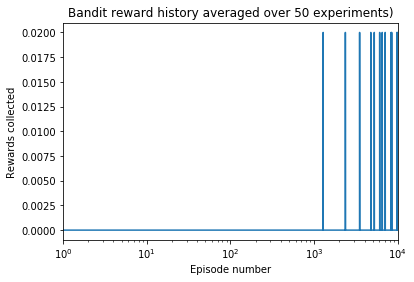

In [84]:
plt.plot(reward_history_avg)
plt.xlabel("Episode number")
plt.ylabel("Rewards collected".format(N_experiments))
plt.title("Bandit reward history averaged over {} experiments)".format(N_experiments, epsilon))
ax = plt.gca()
ax.set_xscale("log", nonposx='clip')
plt.xlim([1, N_episodes])
plt.show()

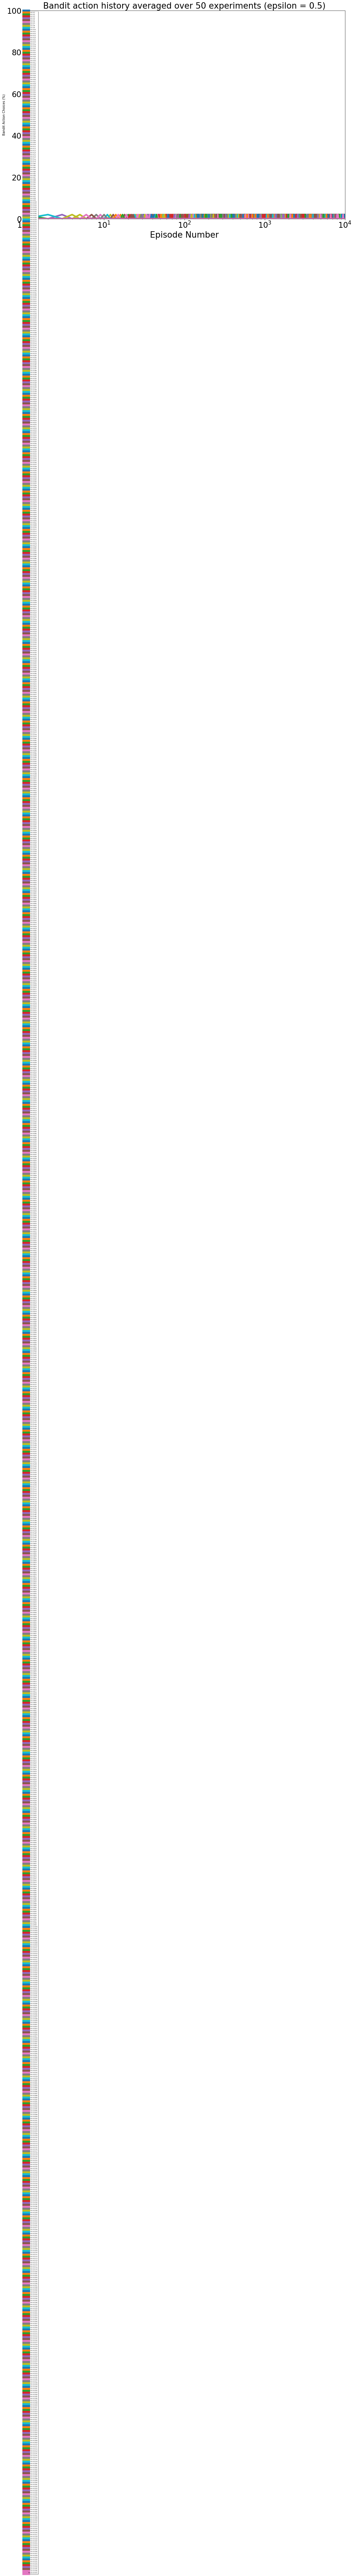

In [44]:
# Plot action history results
plt.figure(figsize=(18, 12))
for i in range(N_bandits):
    action_history_sum_plot = 100 * action_history_sum[:,i] / N_experiments
    plt.plot(list(np.array(range(len(action_history_sum_plot)))+1),action_history_sum_plot,
             linewidth=5.0,
    label="Bandit #{}".format(i+1))
plt.title("Bandit action history averaged over {} experiments (epsilon = {})".format(N_experiments, epsilon), fontsize=26)
plt.xlabel("Episode Number", fontsize=26)
plt.ylabel("Bandit Action Choices (%)", fontsize=10)
leg = plt.legend(loc='upper left', shadow=True, fontsize=4)
ax = plt.gca()
ax.set_xscale("log", nonposx='clip')
plt.xlim([1, N_episodes])
plt.ylim([0, 100])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
for legobj in leg.legendHandles:
    legobj.set_linewidth(16.0)
plt.show()

In [21]:
bandit_selection=action_history+1
df = pd.DataFrame(bandit_selection)

In [22]:
df.to_csv('/home/dt-021/Documents/sagemaker/softmax2.csv')

In [23]:
bandit_selection=reward_history
df1= pd.DataFrame(bandit_selection)

In [24]:
df1.to_csv('/home/dt-021/Documents/sagemaker/reward.csv')

In [25]:
ratio= load_file_from_excel("/home/dt-021/Documents/sagemaker/softmax2.csv")

XLRDError: Unsupported format, or corrupt file: Expected BOF record; found b',0\n0,121'

In [1]:
ratio.head(10)

NameError: name 'ratio' is not defined

In [63]:
softmax=ratio['ID_Selected'].value_counts()

In [64]:
softmax.to_csv('data/softmax3.csv')

In [77]:
N_bandits = len(bandit_probs)
print("Running multi-armed bandits with N_bandits = {} and agent epsilon = {}".format(N_bandits, epsilon))
reward_history_avg = np.zeros(N_episodes)  # reward history experiment-averaged
action_history_sum = np.zeros((N_episodes, N_bandits))  # sum action history
for i in range(N_experiments):
    bandit = Bandit(bandit_probs)  # initialize bandits
    agent = Agent(bandit, epsilon)  # initialize agent
    (action_history, reward_history) = experiment(agent, bandit, N_episodes)  # perform experiment
    print("[Experiment {}/{}]".format(i + 1, N_experiments))
    print("  N_episodes = {}".format(N_episodes))
    print("  bandit choice history = {}".format(action_history + 1))
    print("  reward history = {}".format(reward_history))
    print("  average reward = {}".format(np.sum(reward_history) / len(reward_history)))
    print("")
        # Sum up experiment reward (later to be divided to represent an average)
reward_history_avg += reward_history
        # Sum up action history
for j, (a) in enumerate(action_history):
    action_history_sum[j][a] += 1
reward_history_avg /= np.float(N_experiments)
print("reward history avg = {}".format(reward_history_avg))

Running multi-armed bandits with N_bandits = 1337 and agent epsilon = 0.5
[Experiment 1/50]
  N_episodes = 10000
  bandit choice history = [1107   11    2 ...  109  857 1086]
  reward history = [0 0 0 ... 0 0 0]
  average reward = 0.0011

[Experiment 2/50]
  N_episodes = 10000
  bandit choice history = [1071  520  403 ...  618  853  505]
  reward history = [0 0 0 ... 0 0 0]
  average reward = 0.001

[Experiment 3/50]
  N_episodes = 10000
  bandit choice history = [1028  888  325 ...  370  621   31]
  reward history = [0 0 0 ... 0 0 0]
  average reward = 0.0008

[Experiment 4/50]
  N_episodes = 10000
  bandit choice history = [1193  929 1171 ... 1101  947  763]
  reward history = [0 0 0 ... 0 0 0]
  average reward = 0.0006

[Experiment 5/50]
  N_episodes = 10000
  bandit choice history = [ 310  600 1301 ... 1306  692  457]
  reward history = [0 0 0 ... 0 0 0]
  average reward = 0.0008

[Experiment 6/50]
  N_episodes = 10000
  bandit choice history = [ 236  841  248 ... 1310  493   57]
 

In [12]:
bandit_selection=action_history+1
df = pd.DataFrame(bandit_selection)

In [13]:
df.to_csv('data/CLPS1.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/CLPS1.csv'

In [80]:
R= load_file_from_excel("/Users/nitya/Downloads/PythonForDataScience-master/data/CLPS1.xlsx")

In [81]:
R.head()

,ID_selected
0,1078
1,216
2,682
3,767
4,1117


In [82]:
R['ID_selected'].value_counts()

948     17
39      16
716     16
935     16
359     15
955     15
1275    15
483     15
38      15
94      15
525     15
729     15
854     15
288     14
110     14
868     14
732     14
932     14
1121    14
534     13
58      13
438     13
1315    13
1304    13
856     13
245     13
903     13
640     13
786     13
410     13
        ..
472      3
638      3
548      3
215      3
1331     2
512      2
1330     2
639      2
734      2
390      2
693      2
1131     2
1099     2
763      2
427      2
560      2
387      2
802      2
698      2
482      2
1201     2
1000     2
960      2
634      1
13       1
297      1
920      1
647      1
695      1
8        1
Name: ID_selected, Length: 1337, dtype: int64

In [83]:
R['ID_selected'].value_counts().to_csv('data/CLPS2.csv')